### **Tasks**
1. Calculate how many times the equipment has failed.
During the FPSO’s operation, various factors can cause the machine to fail and prolong its failure state. We ask you to explore the available data, identify, and calculate the number of times the equipment has failed throughout its operation.
2. Categorize equipment failures by setup configurations (Preset 1 and Preset 2).
How do the variables Preset_1 and Preset_2 behave during operation? What insights can we derive from these variables?
3. Categorize equipment failures by their nature/root cause according to parameter readings (temperature, pressure, and others).
Analyze patterns in these readings that could indicate specific failure types. How do these patterns differ across operational regimes? Provide insights based on your findings.
4. Create a model (or models) using the technique you think is most appropriate and measure its performance.
Based on the given time-series dataset, which models or techniques are suitable for predicting whether the equipment will fail before it occurs? Additionally, how can the model's performance be tuned and measured for this task?
5. Analyze variable importance.
After developing a model, how can we determine which variables had the greatest impact on the prediction?

### **1. Library Imports**

In [ ]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np
import itertools
from typing import Dict, Any, Tuple, List
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import fbeta_score
import shap


### **2. Dataset**

The dataset contains anonymized time series records of a machine's operation from an FPSO. The recorded variables are as follows:
1.	Cycle: Sequential identifier of measurement cycles.
2.	Preset_1 & Preset_2: Variables that control a specific operating point of the machine.
3.	Temperature: Temperature recorded in the equipment.
4.	Vibrations (X, Y & Z): Vibrations along the machine's axes.
5.	Frequency: Operating frequency of the machine.
6.	Fail: Variable indicating whether the machine is in a failure state at the given timestamp.

#### **2.1 Data Loading**

In [2]:
df = pd.read_excel("Test O_G_Equipment_Data.xlsx")
print(df.shape)
df.head()

(800, 10)


,Cycle,Preset_1,Preset_2,Temperature,Pressure,VibrationX,VibrationY,VibrationZ,Frequency,Fail
0,1,3,6,44.235186,47.657254,46.441769,64.820327,66.454520,44.483250,False
1,2,2,4,60.807234,63.172076,62.005951,80.714431,81.246405,60.228715,False
2,3,2,1,79.027536,83.032190,82.642110,98.254386,98.785196,80.993479,False
3,4,2,3,79.716242,100.508634,122.362321,121.363429,118.652538,80.315567,False
4,5,2,5,39.989054,51.764833,42.514302,61.037910,50.716469,64.245166,False


#### **2.2 Data Quality Check**

#### **2.2.1 Missing Values Check**

In [3]:
df.isnull().sum()

Cycle          0
Preset_1       0
Preset_2       0
Temperature    0
Pressure       0
VibrationX     0
VibrationY     0
VibrationZ     0
Frequency      0
Fail           0
dtype: int64

#### **2.2.2 Duplicate Check**

In [4]:
# Check for duplicated columns in the DataFrame
duplicated_columns = df.columns[df.columns.duplicated()]

# Check for duplicated rows in the DataFrame
number_of_duplicated_rows = df.duplicated().sum()

# Display the results
print("Duplicated columns:", list(duplicated_columns))
print("Number of duplicated rows:", number_of_duplicated_rows)


Duplicated columns: []
Number of duplicated rows: 0


#### **2.2.3 Feature Uniqueness Check**

In [5]:
df.nunique()

Cycle          800
Preset_1         3
Preset_2         8
Temperature    800
Pressure       800
VibrationX     800
VibrationY     800
VibrationZ     800
Frequency      800
Fail             2
dtype: int64

### **🟥 TASK 1**
- Calculate how many times the equipment has failed.
    - During the FPSO’s operation, various factors can cause the machine to fail and prolong its failure state. We ask you to explore the available data, identify, and calculate the number of times the equipment has failed throughout its operation.


In [6]:
df["Fail"] = df["Fail"].astype(int)

# Counts the number of normal (0) and failure (1) states
df["Fail"].value_counts()

Fail
0    734
1     66
Name: count, dtype: int64

In [7]:
# A new failure is counted when the 'Fail' column transitions from 0 to 1
df["New_Fail"] = df["Fail"].diff() == 1
df["New_Fail"] = df["New_Fail"].astype(int)

# A failure is considered resolved when the 'Fail' column transitions from 1 to 0
df["Resolved_fail"] = (df["Fail"].diff() == -1).astype(int)

print("Number of equipment failures:", df["New_Fail"].sum())
print("Number of resolved equipment failures:", df["Resolved_fail"].sum())

Number of equipment failures: 10
Number of resolved equipment failures: 9


#### **Task 1: Answer**
- A total of 10 distinct failure events were detected, based on transitions from 0 to 1 in the Fail column.
- Additionally, 9 failure resolutions were identified by transitions from 1 to 0.
- This indicates that one failure was still active at the end of the recorded data, which may suggest an ongoing issue or an incomplete recovery log.

### **🟥 TASK 2**
- Categorize equipment failures by setup configurations (Preset 1 and Preset 2).
    - How do the variables Preset_1 and Preset_2 behave during operation? What insights can we derive from these variables?

In [8]:
# Calculates failure rate and share of failures for a categorical column
def analyze_failure_rate(df: pd.DataFrame, column: str) -> pd.DataFrame:
    total = df[column].value_counts().rename("total")
    failures = df[df["Fail"] == 1][column].value_counts().rename("failures")
    result = pd.concat([total, failures], axis=1).fillna(0)
    result["failures"] = result["failures"].astype(int)
    result["failure_rate"] = (result["failures"] / result["total"]).round(4)
    # Share of total failures
    result["failure_share"] = (
        result["failures"] / result["failures"].sum()
    ).round(4)
    result = (
        result.sort_values("failure_rate", ascending=False)
        .reset_index()
        .rename(columns={"index": column})
    )
    return result

# Individual analysis for each preset
table_preset_1 = analyze_failure_rate(df, "Preset_1")
table_preset_2 = analyze_failure_rate(df, "Preset_2")

# Combined analysis for both presets
df["Preset_Combined"] = "Preset_1=" + df["Preset_1"].astype(str) + ", Preset_2=" + df["Preset_2"].astype(str)
table_combined = analyze_failure_rate(df, "Preset_Combined")

In [9]:
table_preset_1

,Preset_1,total,failures,failure_rate,failure_share
0,1,264,27,0.1023,0.4091
1,2,281,21,0.0747,0.3182
2,3,255,18,0.0706,0.2727


In [10]:
table_preset_2

,Preset_2,total,failures,failure_rate,failure_share
0,5,100,12,0.1200,0.1818
1,1,95,11,0.1158,0.1667
2,6,101,9,0.0891,0.1364
3,2,101,9,0.0891,0.1364
4,7,109,9,0.0826,0.1364
5,8,100,7,0.0700,0.1061
6,3,101,6,0.0594,0.0909
7,4,93,3,0.0323,0.0455


In [11]:
table_combined

,Preset_Combined,total,failures,failure_rate,failure_share
0,"Preset_1=1, Preset_2=5",31,5,0.1613,0.0758
1,"Preset_1=3, Preset_2=5",29,4,0.1379,0.0606
2,"Preset_1=2, Preset_2=1",30,4,0.1333,0.0606
3,"Preset_1=1, Preset_2=2",38,5,0.1316,0.0758
4,"Preset_1=1, Preset_2=1",34,4,0.1176,0.0606
5,"Preset_1=2, Preset_2=8",37,4,0.1081,0.0606
6,"Preset_1=1, Preset_2=7",38,4,0.1053,0.0606
7,"Preset_1=3, Preset_2=6",30,3,0.1000,0.0455
8,"Preset_1=3, Preset_2=1",31,3,0.0968,0.0455
9,"Preset_1=1, Preset_2=4",22,2,0.0909,0.0303


In [12]:
# Compares the failure rate of a Target value against the average of all others
def compare_failure_rate_against_others(table, column, Target_value):
    Target_rate = table.loc[table[column] == Target_value, "failure_rate"].values[0]
    average_rate_others = table.loc[table[column] != Target_value, "failure_rate"].mean()
    percent_higher = ((Target_rate - average_rate_others) / average_rate_others) * 100
    percent_higher = round(percent_higher, 2)

    print(
        f"{column} = {Target_value} has the highest failure rate ({Target_rate:.2%}), "
        f"which is approximately {percent_higher}% higher than the average failure rate of "
        f"all other {column} values ({average_rate_others:.2%})."
    )

In [13]:
compare_failure_rate_against_others(table_preset_1, "Preset_1", 1)

Preset_1 = 1 has the highest failure rate (10.23%), which is approximately 40.81% higher than the average failure rate of all other Preset_1 values (7.26%).


In [14]:
compare_failure_rate_against_others(table_preset_2, "Preset_2", 5)

Preset_2 = 5 has the highest failure rate (12.00%), which is approximately 56.05% higher than the average failure rate of all other Preset_2 values (7.69%).


In [15]:
Target_value = table_combined.sort_values("failure_rate", ascending=False).iloc[0]["Preset_Combined"]
compare_failure_rate_against_others(table_combined, "Preset_Combined", Target_value)

Preset_Combined = Preset_1=1, Preset_2=5 has the highest failure rate (16.13%), which is approximately 99.92% higher than the average failure rate of all other Preset_Combined values (8.07%).


In [16]:
table_combined

,Preset_Combined,total,failures,failure_rate,failure_share
0,"Preset_1=1, Preset_2=5",31,5,0.1613,0.0758
1,"Preset_1=3, Preset_2=5",29,4,0.1379,0.0606
2,"Preset_1=2, Preset_2=1",30,4,0.1333,0.0606
3,"Preset_1=1, Preset_2=2",38,5,0.1316,0.0758
4,"Preset_1=1, Preset_2=1",34,4,0.1176,0.0606
5,"Preset_1=2, Preset_2=8",37,4,0.1081,0.0606
6,"Preset_1=1, Preset_2=7",38,4,0.1053,0.0606
7,"Preset_1=3, Preset_2=6",30,3,0.1000,0.0455
8,"Preset_1=3, Preset_2=1",31,3,0.0968,0.0455
9,"Preset_1=1, Preset_2=4",22,2,0.0909,0.0303


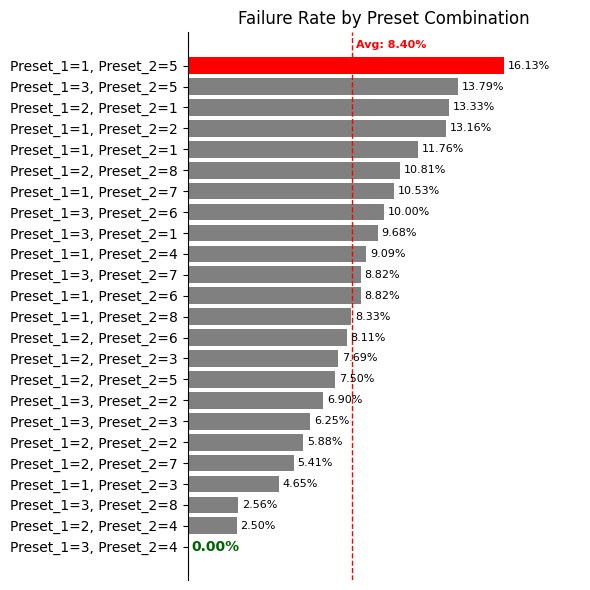

In [17]:
# Generates a failure rate chart by preset combination, highlighting extremes
def plot_failure_rate_by_combination(df: pd.DataFrame) -> None:
    df_plot = df.copy().sort_values("failure_rate", ascending=False)
    max_rate: float = df_plot["failure_rate"].max()
    avg_rate: float = df_plot["failure_rate"].mean()

    colors: list[str] = [
        "red" if rate == max_rate else "gray" if rate > 0 else "darkgreen"
        for rate in df_plot["failure_rate"]
    ]

    plt.figure(figsize=(6, 6))
    bars = plt.barh(df_plot["Preset_Combined"], df_plot["failure_rate"], color=colors)

    # Adds percentage labels on the bars
    for bar, rate in zip(bars, df_plot["failure_rate"]):
        width = bar.get_width()
        color = "darkgreen" if rate == 0 else "black"
        weight = "bold" if rate == 0 else "normal"
        size = 10 if rate == 0 else 8

        plt.text(
            width + 0.002,
            bar.get_y() + bar.get_height() / 2,
            f"{width:.2%}",
            va="center",
            fontsize=size,
            color=color,
            fontweight=weight,
        )

    # Draws a dashed red line for the average failure rate
    plt.axvline(avg_rate, color="red", linestyle="--", linewidth=1)
    plt.text(
        avg_rate + 0.002,
        -0.85,
        f"Avg: {avg_rate:.2%}",
        color="red",
        fontsize=8,
        fontweight="bold",
    )

    # Remove X-axis labels and ticks
    plt.xticks([])
    plt.xlabel("")
    plt.xlim(0, 0.2)
    plt.title("Failure Rate by Preset Combination")

    ax = plt.gca()
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["right"].set_visible(False)

    ax.invert_yaxis()
    plt.tight_layout()
    plt.show()


plot_failure_rate_by_combination(table_combined)


#### **Task 2: Answer**

- Preset_1
    - `Preset_1 = 1` had the **highest failure rate** (**10.23%**), which is approximately **40.81% higher** than the failure rates observed for the other values (`Preset_1 = 2` at 7.47% and `Preset_1 = 3` at 7.06%).
    - There is an **inversely proportional relationship** between the value of `Preset_1` and the failure rate: as the preset value increases, the failure rate decreases.
    - Approximately **40.9% of all failures** occurred when `Preset_1 = 1`.
        - This suggests that this configuration is associated with higher operational risk and **warrants deeper investigation** regarding its usage context and impact on equipment reliability.


- Preset_2
    - `Preset_2 = 5` had the **highest failure rate** (**12.00%**), which is approximately **56.05% higher** than the average failure rate observed for the other values (`Preset_2 ≠ 5`, average at **7.69%**).
    - The failure rate decreases across several other preset values, suggesting that higher values of `Preset_2` are not necessarily associated with increased failure — the relationship is **non-linear** and requires deeper contextual analysis.
    - Approximately **18.2% of all failures** occurred when `Preset_2 = 5`.
        - This suggests that this configuration represents a critical risk scenario and **should be prioritized for operational monitoring and root cause analysis**.

- Combined Presets (`Preset_1` + `Preset_2`)
    - The combination `Preset_1 = 1, Preset_2 = 5` had the **highest failure rate** among all configurations (**16.13%**), which is approximately **90.2% higher** than the average failure rate of the other combined configurations (**8.48%**).
    - This combination also accounted for **7.58% of all failures**, despite representing a smaller portion of the dataset, which reinforces its **disproportionate operational risk**.
    - On the other hand, the combination `Preset_1 = 3, Preset_2 = 4` showed a **0.00% failure rate**, with **no failures recorded** across all its cycles.
    - These findings highlight the need to **not only analyze presets individually**, but also understand how their **interaction amplifies failure risk**.
        - The configuration `Preset_1 = 1, Preset_2 = 5` should be flagged as **high priority for preventive measures**, including predictive maintenance, operational review, and parameter reassessment.



### **🟥 TASK 3**
- Categorize equipment failures by their nature/root cause according to parameter readings (temperature, pressure, and others).
    - Analyze patterns in these readings that could indicate specific failure types. How do these patterns differ across operational regimes? Provide insights based on your findings.

In [18]:
features = ["Temperature", "Pressure", "VibrationX", "VibrationY", "VibrationZ", "Frequency"]

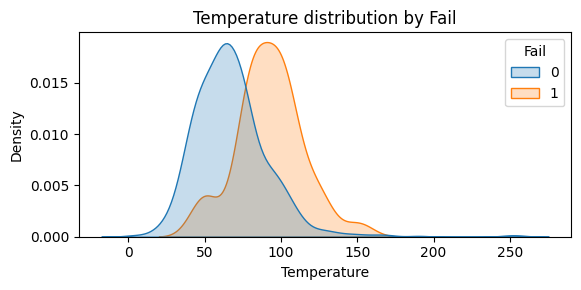

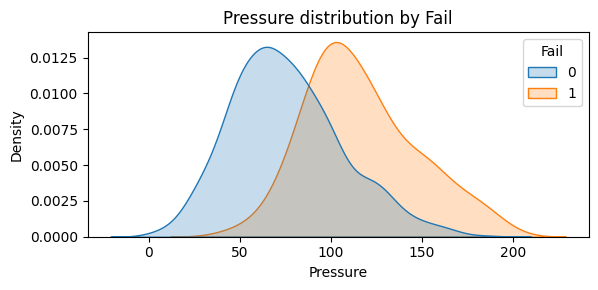

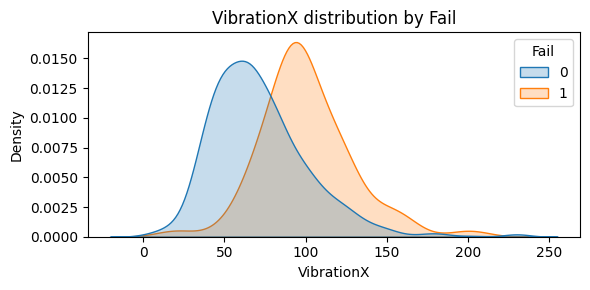

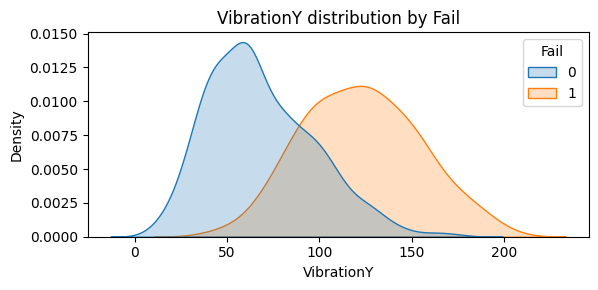

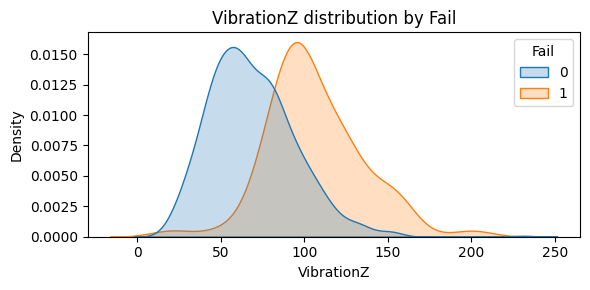

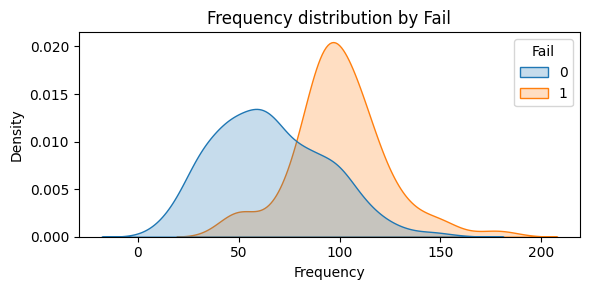

In [19]:
def plot_distributions_by_failure(df: pd.DataFrame, features: list[str]) -> None:
    for col in features:
        plt.figure(figsize=(6, 3))
        sns.kdeplot(data=df, x=col, hue="Fail", common_norm=False, fill=True)
        plt.title(f"{col} distribution by Fail")
        plt.tight_layout()
        plt.show()

plot_distributions_by_failure(df, features)

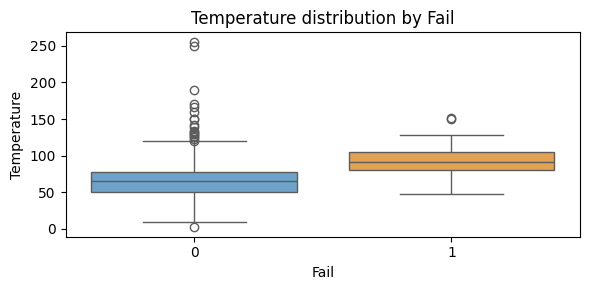

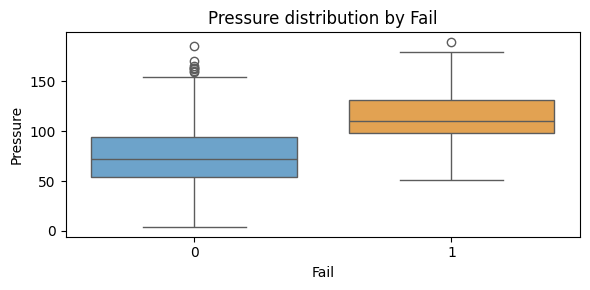

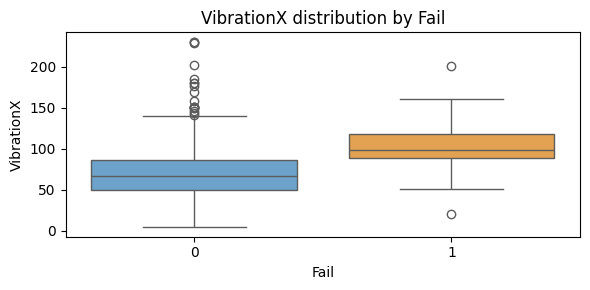

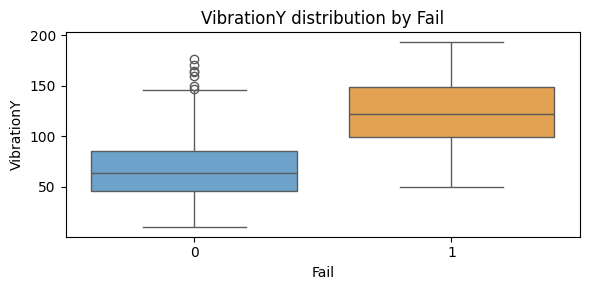

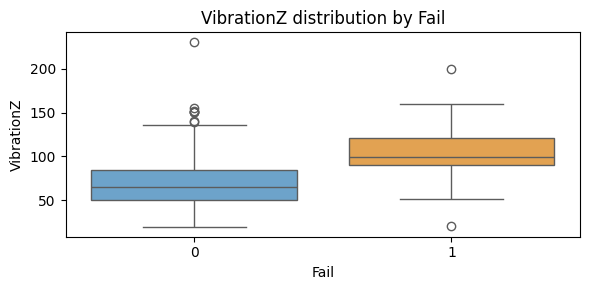

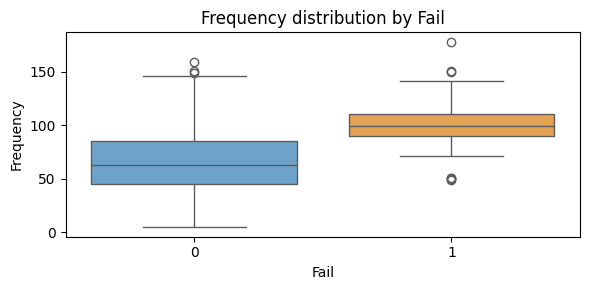

In [20]:
# Plots boxplots comparing distributions by failure status
def plot_boxplots_by_failure(df: pd.DataFrame, features: list[str]) -> None:
    # Iterates through the variables to generate boxplots split by failure
    for feature in features:
        plt.figure(figsize=(6, 3))
        sns.boxplot(
            data=df,
            x="Fail",
            y=feature,
            hue="Fail",
            palette={0: "#5DA5DA", 1: "#FAA43A"},  # Blue for 0, orange for 1
            legend=False
        )
        plt.title(f"{feature} distribution by Fail")
        plt.xlabel("Fail")
        plt.tight_layout()
        plt.show()

plot_boxplots_by_failure(df, features)


In [21]:
# Classifies each variable into 'low', 'normal', or 'high' based on its own quartiles
def categorize_by_quartile(df: pd.DataFrame, variables: list[str]) -> pd.DataFrame:
    # Creates a copy to avoid modifying the original
    df_categorized = df.copy()
    
    # Iterates over each variable
    for var in variables:
        # Calculates Q1 and Q3
        q1 = df[var].quantile(0.25)
        q3 = df[var].quantile(0.75)
        
        # Applies classification logic
        df_categorized[f"{var}_level"] = df[var].apply(
            lambda x: "high" if x > q3 else ("low" if x < q1 else "normal")
        )
    
    return df_categorized

df_labeled = categorize_by_quartile(df, features)

df_labeled.head()


,Cycle,Preset_1,Preset_2,Temperature,Pressure,VibrationX,VibrationY,VibrationZ,Frequency,Fail,New_Fail,Resolved_fail,Preset_Combined,Temperature_level,Pressure_level,VibrationX_level,VibrationY_level,VibrationZ_level,Frequency_level
0,1,3,6,44.235186,47.657254,46.441769,64.820327,66.454520,44.483250,0,0,0,"Preset_1=3, Preset_2=6",low,low,low,normal,normal,low
1,2,2,4,60.807234,63.172076,62.005951,80.714431,81.246405,60.228715,0,0,0,"Preset_1=2, Preset_2=4",normal,normal,normal,normal,normal,normal
2,3,2,1,79.027536,83.032190,82.642110,98.254386,98.785196,80.993479,0,0,0,"Preset_1=2, Preset_2=1",normal,normal,normal,high,high,normal
3,4,2,3,79.716242,100.508634,122.362321,121.363429,118.652538,80.315567,0,0,0,"Preset_1=2, Preset_2=3",normal,high,high,high,high,normal
4,5,2,5,39.989054,51.764833,42.514302,61.037910,50.716469,64.245166,0,0,0,"Preset_1=2, Preset_2=5",low,low,low,normal,low,normal


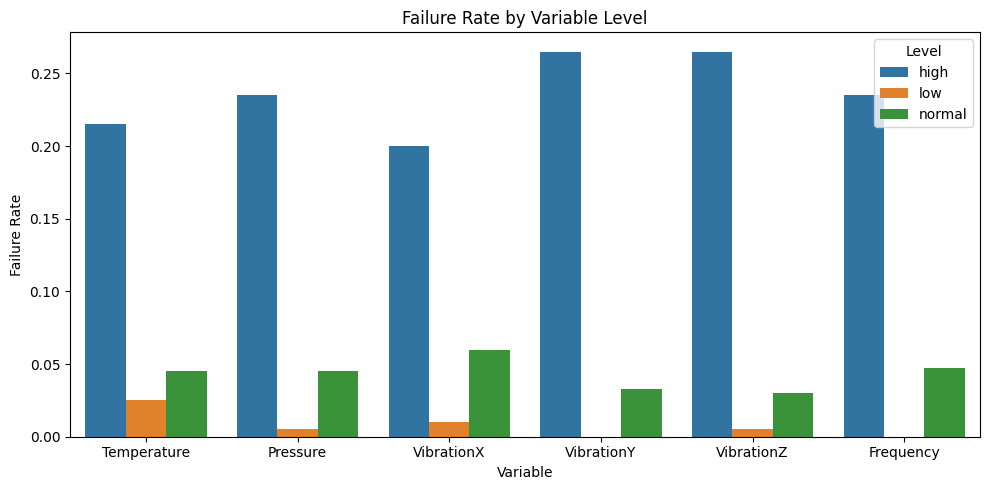

In [22]:
# Calculates failure rate per level
def failure_rate_by_level(df: pd.DataFrame, variables: list[str]) -> pd.DataFrame:
    resultados = []
    for var in variables:
        level_col = f"{var}_level"
        taxa = df.groupby(level_col)["Fail"].mean().reset_index()
        taxa["variable"] = var
        taxa.rename(columns={level_col: "level", "Fail": "failure_rate"}, inplace=True)
        resultados.append(taxa)
    return pd.concat(resultados, ignore_index=True)

# Applies categorization and computes failure rates
df_labeled = categorize_by_quartile(df, features)
failure_analysis = failure_rate_by_level(df_labeled, features)

# Plots the result
plt.figure(figsize=(10, 5))
sns.barplot(data=failure_analysis, x="variable", y="failure_rate", hue="level")
plt.title("Failure Rate by Variable Level")
plt.ylabel("Failure Rate")
plt.xlabel("Variable")
plt.legend(title="Level")
plt.tight_layout()
plt.show()

In [23]:
# Performs KMeans clustering with silhouette-based selection using 95% threshold
def cluster_failures_by_sensor_pattern(df: pd.DataFrame, features: list[str], k_min: int = 2, k_max: int = 10) -> tuple:
    # Filters only failure cases
    df_failure = df[df["Fail"] == 1].copy()

    # Standardizes the sensor features
    scaler = StandardScaler()
    sensor_scaled = scaler.fit_transform(df_failure[features])

    # Finds the best k using silhouette score with threshold
    silhouette_scores = []
    for k in range(k_min, k_max):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(sensor_scaled)
        score = silhouette_score(sensor_scaled, labels)
        silhouette_scores.append(score)

    max_score = max(silhouette_scores)
    threshold = 0.95 * max_score

    # Selects the smallest k satisfying the threshold
    best_k = next(k for k, score in zip(range(k_min, k_max), silhouette_scores) if score >= threshold)

    # Final KMeans with best_k
    kmeans_final = KMeans(n_clusters=best_k, random_state=42, n_init=10)
    df_failure["failure_cluster"] = kmeans_final.fit_predict(sensor_scaled)

    # Summarizes sensor means per cluster
    cluster_summary = df_failure.groupby("failure_cluster")[features].mean().round(1)

    return df_failure, cluster_summary

df_failure_labeled, cluster_summary = cluster_failures_by_sensor_pattern(df, features, k_min=2, k_max=8)
cluster_summary



,Temperature,Pressure,VibrationX,VibrationY,VibrationZ,Frequency
failure_cluster,,,,,,
0,68.3,77.8,149.1,78.6,148.1,64.4
1,79.2,130.3,77.6,145.2,89.3,123.1
2,101.6,116.0,102.9,119.0,107.2,94.9


In [24]:
# Extract Q1 and Q3 thresholds from df_labeled
def get_quartile_thresholds(df: pd.DataFrame, variables: list[str]) -> dict:
    return {
        var: {
            "q1": df[var].quantile(0.25),
            "q3": df[var].quantile(0.75)
        } for var in variables
    }

# Classify cluster means based on those thresholds
def classify_cluster_summary_levels(cluster_summary: pd.DataFrame, thresholds: dict) -> pd.DataFrame:
    cluster_labeled = cluster_summary.copy()
    for var in thresholds:
        q1 = thresholds[var]["q1"]
        q3 = thresholds[var]["q3"]
        cluster_labeled[var] = cluster_summary[var].apply(
            lambda x: "high" if x > q3 else ("low" if x < q1 else "normal")
        )
    return cluster_labeled

# Apply mapping
thresholds = get_quartile_thresholds(df_labeled, features)
cluster_config = classify_cluster_summary_levels(cluster_summary, thresholds)

cluster_config


,Temperature,Pressure,VibrationX,VibrationY,VibrationZ,Frequency
failure_cluster,,,,,,
0,normal,normal,high,normal,high,normal
1,normal,high,normal,high,high,high
2,high,high,high,high,high,high


In [25]:
# Computes Spearman correlation between numeric features and the Target variable
def spearman_correlation_with_Target(df: pd.DataFrame, features: list[str], Target: str = "Fail") -> pd.DataFrame:
    # Calculates correlation for each feature
    correlacoes = {
        feature: df[[feature, Target]].corr(method="spearman").iloc[0, 1]
        for feature in features
    }
    
    # Converts to sorted DataFrame
    resultado = pd.DataFrame.from_dict(correlacoes, orient="index", columns=["spearman_corr"])
    resultado = resultado.sort_values("spearman_corr", key=abs, ascending=False).reset_index()
    resultado.rename(columns={"index": "feature"}, inplace=True)
    
    return resultado

correlation_result = spearman_correlation_with_Target(df, features)

correlation_result

,feature,spearman_corr
0,VibrationY,0.377140
1,VibrationZ,0.335157
2,Pressure,0.319064
3,Frequency,0.313674
4,Temperature,0.296204
5,VibrationX,0.275350


#### **Task 3 - Answer**

Equipment failures were categorized based on sensor patterns identified from temperature, pressure, vibration (X, Y, Z), and frequency data. Using clustering analysis on failure cases, three distinct failure profiles were identified, each representing a different root cause and operational regime.

All analyzed sensors show consistently higher values during failure cycles, reinforcing the hypothesis that failures result from stressed operating conditions, especially in temperature, vibration, and frequency. This provides a solid foundation for predictive monitoring based on dynamic sensor thresholds.

The three identified failure profiles are:

1. **Localized Mechanical Failure** 
    — Elevated vibration along the X and Z axes, with other parameters (pressure, temperature, frequency) remaining normal. Indicates a localized mechanical issue such as imbalance or misalignment, without compromising overall system performance.

2. **Hydraulic or Pneumatic Overload** 
    — High pressure and frequency, with increased vibration in the Y and Z axes. Suggests the system is compensating for restricted flow or partial blockage, causing broader mechanical stress.

3. **Critical Generalized Failure** 
    — All sensor readings are elevated. This is the most severe scenario, indicating thermal overload, intense vibration, and excessive pressure. Likely related to cooling system failure, excessive operational demand, or prolonged operation beyond design limits.

These patterns clearly differ across operational regimes: from isolated mechanical symptoms under otherwise stable conditions (Cluster 1), to systemic overload (Cluster 2), and full-system stress under extreme conditions (Cluster 3). This categorization enables Targeted interventions and supports condition-based maintenance strategies.

### **🟥 TASK 4**
- Create a model (or models) using the technique you think is most appropriate and measure its performance.
    - Based on the given time-series dataset, which models or techniques are suitable for predicting whether the equipment will fail before it occurs? Additionally, how can the model's performance be tuned and measured for this task?

In [26]:
# Preserves the temporal order
df.sort_values("Cycle", inplace=True)

In [27]:
# Labels pre-failure behavior using the window_size cycles before each new failure
def label_pre_failure_window(df: pd.DataFrame,  window_size: int = 6) -> pd.DataFrame:
    # Creates a copy to preserve the original DataFrame
    df_labeled = df.copy()
    df_labeled["Target"] = 0

    # Identifies the indices where a new failure occurs
    New_Failure_indices = df_labeled.index[df_labeled["New_Fail"] == 1]

    # Iterates over each new failure index
    for idx in New_Failure_indices:
        # Selects the 6 previous records where Fail == 0
        start_idx = max(0, idx - window_size)
        window = df_labeled.iloc[start_idx:idx]
        valid_indices = window[window["Fail"] == 0].index[-window_size:]

        # Marks those records as Target = 1
        df_labeled.loc[valid_indices, "Target"] = 1

    return df_labeled


df = label_pre_failure_window(df)

display(df["Target"].value_counts())
print(df.columns)
df

Target
0    748
1     52
Name: count, dtype: int64

Index(['Cycle', 'Preset_1', 'Preset_2', 'Temperature', 'Pressure',
       'VibrationX', 'VibrationY', 'VibrationZ', 'Frequency', 'Fail',
       'New_Fail', 'Resolved_fail', 'Preset_Combined', 'Target'],
      dtype='object')


,Cycle,Preset_1,Preset_2,Temperature,Pressure,VibrationX,VibrationY,VibrationZ,Frequency,Fail,New_Fail,Resolved_fail,Preset_Combined,Target
0,1,3,6,44.235186,47.657254,46.441769,64.820327,66.454520,44.483250,0,0,0,"Preset_1=3, Preset_2=6",0
1,2,2,4,60.807234,63.172076,62.005951,80.714431,81.246405,60.228715,0,0,0,"Preset_1=2, Preset_2=4",0
2,3,2,1,79.027536,83.032190,82.642110,98.254386,98.785196,80.993479,0,0,0,"Preset_1=2, Preset_2=1",0
3,4,2,3,79.716242,100.508634,122.362321,121.363429,118.652538,80.315567,0,0,0,"Preset_1=2, Preset_2=3",0
4,5,2,5,39.989054,51.764833,42.514302,61.037910,50.716469,64.245166,0,0,0,"Preset_1=2, Preset_2=5",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,796,2,6,50.469522,98.235421,151.585252,99.341380,148.838481,49.841400,1,0,0,"Preset_1=2, Preset_2=6",0
796,797,1,4,49.985270,160.433640,110.953010,160.777175,109.917566,110.919290,1,0,0,"Preset_1=1, Preset_2=4",0
797,798,1,4,79.777294,110.535405,61.334995,149.577811,129.463843,70.853353,1,0,0,"Preset_1=1, Preset_2=4",0
798,799,2,8,79.360314,159.985443,61.762879,169.773831,130.213426,80.113540,1,0,0,"Preset_1=2, Preset_2=8",0


In [28]:
# Computes cumulative failure rate per category up to the current row (excluding it)
def encode_categorical_fail_rate(
    df: pd.DataFrame, categorical_columns: List[str]
) -> pd.DataFrame:
    df_encoded = df.copy()

    for col in categorical_columns:
        df_encoded[f"Fail_Rate_{col}"] = 0.0
        count_tracker = {}
        fail_tracker = {}

        # Iterates through each row to compute fail rate without data leakage
        for i in range(len(df_encoded)):
            category = df_encoded.loc[i, col]
            total = count_tracker.get(category, 0)
            fails = fail_tracker.get(category, 0)

            # Assigns cumulative fail rate up to current row
            fail_rate = round(100*fails / total,2) if total > 0 else 0.0
            df_encoded.loc[i, f"Fail_Rate_{col}"] = fail_rate

            # Updates trackers
            count_tracker[category] = total + 1
            if df_encoded.loc[i, "Fail"] == 1:
                fail_tracker[category] = fails + 1

    return df_encoded


# Defines the columns to encode
categorical_columns = ["Preset_Combined", "Preset_1", "Preset_2"]

# Applies the encoding
df = encode_categorical_fail_rate(df, categorical_columns)
df


,Cycle,Preset_1,Preset_2,Temperature,Pressure,VibrationX,VibrationY,VibrationZ,Frequency,Fail,New_Fail,Resolved_fail,Preset_Combined,Target,Fail_Rate_Preset_Combined,Fail_Rate_Preset_1,Fail_Rate_Preset_2
0,1,3,6,44.235186,47.657254,46.441769,64.820327,66.454520,44.483250,0,0,0,"Preset_1=3, Preset_2=6",0,0.00,0.00,0.00
1,2,2,4,60.807234,63.172076,62.005951,80.714431,81.246405,60.228715,0,0,0,"Preset_1=2, Preset_2=4",0,0.00,0.00,0.00
2,3,2,1,79.027536,83.032190,82.642110,98.254386,98.785196,80.993479,0,0,0,"Preset_1=2, Preset_2=1",0,0.00,0.00,0.00
3,4,2,3,79.716242,100.508634,122.362321,121.363429,118.652538,80.315567,0,0,0,"Preset_1=2, Preset_2=3",0,0.00,0.00,0.00
4,5,2,5,39.989054,51.764833,42.514302,61.037910,50.716469,64.245166,0,0,0,"Preset_1=2, Preset_2=5",0,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,796,2,6,50.469522,98.235421,151.585252,99.341380,148.838481,49.841400,1,0,0,"Preset_1=2, Preset_2=6",0,5.56,6.81,8.00
796,797,1,4,49.985270,160.433640,110.953010,160.777175,109.917566,110.919290,1,0,0,"Preset_1=1, Preset_2=4",0,0.00,9.54,1.10
797,798,1,4,79.777294,110.535405,61.334995,149.577811,129.463843,70.853353,1,0,0,"Preset_1=1, Preset_2=4",0,4.76,9.89,2.17
798,799,2,8,79.360314,159.985443,61.762879,169.773831,130.213426,80.113540,1,0,0,"Preset_1=2, Preset_2=8",0,8.33,7.14,6.06


In [29]:
fail_rate_check = df[["Cycle", "Preset_1", "Preset_2", "Preset_Combined","Fail", "Target"] + [f"Fail_Rate_{col}" for col in categorical_columns]]
fail_rate_check

,Cycle,Preset_1,Preset_2,Preset_Combined,Fail,Target,Fail_Rate_Preset_Combined,Fail_Rate_Preset_1,Fail_Rate_Preset_2
0,1,3,6,"Preset_1=3, Preset_2=6",0,0,0.00,0.00,0.00
1,2,2,4,"Preset_1=2, Preset_2=4",0,0,0.00,0.00,0.00
2,3,2,1,"Preset_1=2, Preset_2=1",0,0,0.00,0.00,0.00
3,4,2,3,"Preset_1=2, Preset_2=3",0,0,0.00,0.00,0.00
4,5,2,5,"Preset_1=2, Preset_2=5",0,0,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...
795,796,2,6,"Preset_1=2, Preset_2=6",1,0,5.56,6.81,8.00
796,797,1,4,"Preset_1=1, Preset_2=4",1,0,0.00,9.54,1.10
797,798,1,4,"Preset_1=1, Preset_2=4",1,0,4.76,9.89,2.17
798,799,2,8,"Preset_1=2, Preset_2=8",1,0,8.33,7.14,6.06


In [30]:
df.drop(columns=[ "New_Fail", "Resolved_fail", "Preset_Combined"], inplace=True,errors='ignore')
df

,Cycle,Preset_1,Preset_2,Temperature,Pressure,VibrationX,VibrationY,VibrationZ,Frequency,Fail,Target,Fail_Rate_Preset_Combined,Fail_Rate_Preset_1,Fail_Rate_Preset_2
0,1,3,6,44.235186,47.657254,46.441769,64.820327,66.454520,44.483250,0,0,0.00,0.00,0.00
1,2,2,4,60.807234,63.172076,62.005951,80.714431,81.246405,60.228715,0,0,0.00,0.00,0.00
2,3,2,1,79.027536,83.032190,82.642110,98.254386,98.785196,80.993479,0,0,0.00,0.00,0.00
3,4,2,3,79.716242,100.508634,122.362321,121.363429,118.652538,80.315567,0,0,0.00,0.00,0.00
4,5,2,5,39.989054,51.764833,42.514302,61.037910,50.716469,64.245166,0,0,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,796,2,6,50.469522,98.235421,151.585252,99.341380,148.838481,49.841400,1,0,5.56,6.81,8.00
796,797,1,4,49.985270,160.433640,110.953010,160.777175,109.917566,110.919290,1,0,0.00,9.54,1.10
797,798,1,4,79.777294,110.535405,61.334995,149.577811,129.463843,70.853353,1,0,4.76,9.89,2.17
798,799,2,8,79.360314,159.985443,61.762879,169.773831,130.213426,80.113540,1,0,8.33,7.14,6.06


In [31]:
from typing import Union
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
)
import pandas as pd


# Evaluates a binary classifier with accuracy, F1 score, and confusion matrix
def evaluate_model(
    model: xgb.Booster,
    X: Union[pd.DataFrame, np.ndarray],
    y_true: Union[pd.Series, np.ndarray],
    dataset_name: str,
    probability_threshold: float = 0.5,
) -> None:
    dmatrix = xgb.DMatrix(X)
    y_proba: np.ndarray = model.predict(dmatrix)
    y_pred: np.ndarray = (y_proba >= probability_threshold).astype(int)

    print(f"{dataset_name}:")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("F1 Score (macro):", f1_score(y_true, y_pred, average="macro", zero_division=0))
    print("Classification Report:\n", classification_report(y_true, y_pred, zero_division=0))

    matrix: np.ndarray = confusion_matrix(y_true, y_pred, labels=[0, 1])

    plt.figure(figsize=(4, 3))
    ax = sns.heatmap(
        matrix,
        annot=True,
        fmt="d",
        cmap="Purples",
        cbar=False,
        xticklabels=["0", "1"],
        yticklabels=["0", "1"],
    )
    ax.set_xlabel("Predicted Class")
    ax.set_ylabel("True Class")
    ax.set_xticklabels(["0", "1"], rotation=45, ha="right")
    ax.set_yticklabels(["0", "1"], rotation=0)
    plt.title(f"Confusion Matrix - {dataset_name}")
    plt.tight_layout()
    plt.show()

    print("-" * 100)


In [32]:
from typing import Dict, Any, List, Tuple, Union
import pandas as pd
import numpy as np
import xgboost as xgb
import itertools
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import f1_score, fbeta_score, precision_score, recall_score

# Sets the decision threshold for classification
threshold: float = 0.45

# Splits features and target
X: pd.DataFrame = df.drop(columns=["Target"])
y: pd.Series = df["Target"]

# Configures time-based cross-validation and class weight handling
tscv: TimeSeriesSplit = TimeSeriesSplit(n_splits=3)
weight: float = y.value_counts()[0] / y.value_counts()[1] if y.value_counts()[1] > 0 else 1.0

# Defines hyperparameter grid
param_grid: Dict[str, List[Union[int, float]]] = {
    "learning_rate": [0.01, 0.03, 0.05],
    "max_depth": [3, 4],
    "num_boost_round": [100, 200],
    "subsample": [0.65, 0.75],
    "colsample_bytree": [0.65, 0.75],
    "scale_pos_weight": [weight, 5 * weight, 7 * weight],
}

# Generates all hyperparameter combinations
grid_list: List[Tuple[float, int, int, float, float, float]] = list(itertools.product(
    param_grid["learning_rate"],
    param_grid["max_depth"],
    param_grid["num_boost_round"],
    param_grid["subsample"],
    param_grid["colsample_bytree"],
    param_grid["scale_pos_weight"],
))

# Initializes tracking variables
best_score: float = -np.inf
best_params: Dict[str, Union[int, float, str]] = {}
best_models: List[xgb.Booster] = []
best_indices: List[np.ndarray] = []
grid_results: List[Dict[str, Union[int, float]]] = []

# Performs grid search with time-based cross-validation
for lr, md, n_rounds, subsample, colsample, spw in grid_list:
    params: Dict[str, Union[int, float, str]] = {
        "objective": "binary:logistic",
        "eval_metric": "logloss",
        "learning_rate": float(lr),
        "max_depth": int(md),
        "subsample": float(subsample),
        "colsample_bytree": float(colsample),
        "scale_pos_weight": float(spw),
    }

    f1_scores: List[float] = []
    f2_scores: List[float] = []
    precisions: List[float] = []
    recalls: List[float] = []
    errors: List[int] = []
    fold_models: List[xgb.Booster] = []
    fold_indices: List[np.ndarray] = []

    for train_idx, val_idx in tscv.split(X):
        dtrain = xgb.DMatrix(X.iloc[train_idx], label=y.iloc[train_idx])
        dval = xgb.DMatrix(X.iloc[val_idx], label=y.iloc[val_idx])

        model: xgb.Booster = xgb.train(
            params,
            dtrain,
            num_boost_round=int(n_rounds),
            evals=[(dval, "validation")],
            early_stopping_rounds=10,
            verbose_eval=False,
        )

        y_true: pd.Series = y.iloc[val_idx]
        y_pred: np.ndarray = (model.predict(dval) >= threshold).astype(int)

        f1_scores.append(f1_score(y_true, y_pred, zero_division=0))
        f2_scores.append(fbeta_score(y_true, y_pred, beta=2, zero_division=0))
        precisions.append(precision_score(y_true, y_pred, zero_division=0))
        recalls.append(recall_score(y_true, y_pred, zero_division=0))
        errors.append(int(np.sum(y_true != y_pred)))

        fold_models.append(model)
        fold_indices.append(val_idx)

    mean_f1: float = np.mean(f1_scores)
    mean_f2: float = np.mean(f2_scores)
    mean_precision: float = np.mean(precisions)
    mean_recall: float = np.mean(recalls)
    total_errors: int = int(np.sum(errors))

    grid_results.append({
        "mean_f1": mean_f1,
        "mean_f2": mean_f2,
        "mean_precision": mean_precision,
        "mean_recall": mean_recall,
        "sum_errors": total_errors,
        "learning_rate": float(lr),
        "max_depth": int(md),
        "num_boost_round": int(n_rounds),
        "subsample": float(subsample),
        "colsample_bytree": float(colsample),
        "scale_pos_weight": float(spw),
    })

    if mean_f2 > best_score:
        best_score = mean_f2
        best_params = params.copy()
        best_params["num_boost_round"] = int(n_rounds)
        best_models = fold_models
        best_indices = fold_indices

# Builds summary DataFrame of all grid search results
df_results: pd.DataFrame = pd.DataFrame(grid_results)
df_results = df_results.sort_values(by="mean_f2", ascending=False).reset_index(drop=True)

df_results


,mean_f1,mean_f2,mean_precision,mean_recall,sum_errors,learning_rate,max_depth,num_boost_round,subsample,colsample_bytree,scale_pos_weight
0,0.171455,0.281795,0.105072,0.561111,227,0.01,3,100,0.75,0.65,71.923077
1,0.150454,0.262821,0.088596,0.588889,253,0.01,3,100,0.75,0.65,100.692308
2,0.184854,0.261030,0.133147,0.488889,214,0.01,3,100,0.75,0.75,100.692308
3,0.177129,0.253372,0.124000,0.450000,197,0.01,4,100,0.65,0.65,100.692308
4,0.151869,0.253220,0.092594,0.533333,244,0.01,3,100,0.65,0.65,100.692308
...,...,...,...,...,...,...,...,...,...,...,...
139,0.000000,0.000000,0.000000,0.000000,45,0.05,3,200,0.75,0.75,71.923077
140,0.000000,0.000000,0.000000,0.000000,41,0.03,3,200,0.75,0.75,14.384615
141,0.000000,0.000000,0.000000,0.000000,41,0.05,4,100,0.65,0.65,14.384615
142,0.000000,0.000000,0.000000,0.000000,37,0.03,3,200,0.75,0.65,14.384615


In [33]:
best_model = df_results.sort_values("mean_f2", ascending= False)
best_model = best_model.iloc[0]
best_model

mean_f1               0.171455
mean_f2               0.281795
mean_precision        0.105072
mean_recall           0.561111
sum_errors          227.000000
learning_rate         0.010000
max_depth             3.000000
num_boost_round     100.000000
subsample             0.750000
colsample_bytree      0.650000
scale_pos_weight     71.923077
Name: 0, dtype: float64

Train Report: {'0': {'precision': 1.0, 'recall': 0.754601226993865, 'f1-score': 0.8601398601398601, 'support': 489.0}, '1': {'precision': 0.2052980132450331, 'recall': 1.0, 'f1-score': 0.34065934065934067, 'support': 31.0}, 'accuracy': 0.7692307692307693, 'macro avg': {'precision': 0.6026490066225165, 'recall': 0.8773006134969326, 'f1-score': 0.6003996003996004, 'support': 520.0}, 'weighted avg': {'precision': 0.9526235354049923, 'recall': 0.7692307692307693, 'f1-score': 0.8291708291708291, 'support': 520.0}}
Test Report: {'0': {'precision': 0.95, 'recall': 0.7335907335907336, 'f1-score': 0.8278867102396514, 'support': 259.0}, '1': {'precision': 0.1375, 'recall': 0.5238095238095238, 'f1-score': 0.21782178217821782, 'support': 21.0}, 'accuracy': 0.7178571428571429, 'macro avg': {'precision': 0.54375, 'recall': 0.6287001287001287, 'f1-score': 0.5228542462089346, 'support': 280.0}, 'weighted avg': {'precision': 0.8890624999999999, 'recall': 0.7178571428571429, 'f1-score': 0.78213184063504

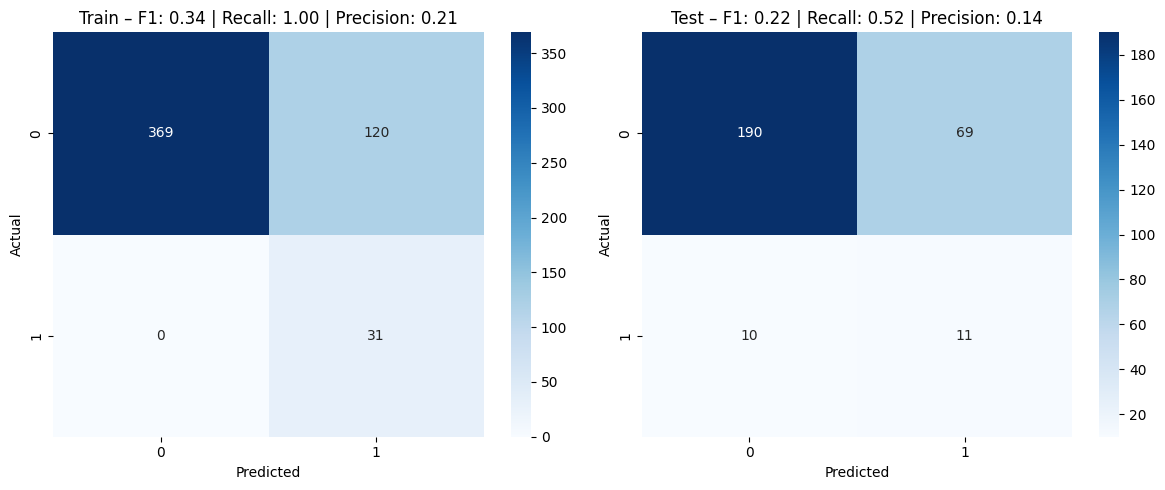

In [34]:
import pandas as pd
import numpy as np
from typing import List, Tuple, Dict, Any
from xgboost import XGBClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
)
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Creates rolling mean and delta features
def create_temporal_features(df: pd.DataFrame, base_columns: List[str]) -> pd.DataFrame:
    df = df.copy()
    for col in base_columns:
        df[f"{col.lower()}_mean_3"] = df[col].rolling(window=3, min_periods=1).mean()
        df[f"{col.lower()}_mean_5"] = df[col].rolling(window=5, min_periods=1).mean()
        df[f"{col.lower()}_delta"] = df[col].diff().fillna(0)
    return df

# Trains final production model with optimal hyperparameters
def train_production_model(
    df: pd.DataFrame,
    best_params: Dict[str, Any],
    threshold: float = 0.65,
) -> Tuple[XGBClassifier, Dict[str, Any], Tuple[pd.DataFrame, pd.Series, np.ndarray], Tuple[pd.DataFrame, pd.Series, np.ndarray], List[str]]:
    df = df.copy()
    df["target"] = df["Target"]

    base_columns: List[str] = ["Temperature", "Pressure", "VibrationX", "VibrationY", "VibrationZ", "Frequency"]
    df = create_temporal_features(df, base_columns)

    feature_columns: List[str] = [
        col for col in df.columns
        if col.startswith(("temperature", "pressure", "vibration", "frequency"))
        and col not in base_columns
    ]
    X: pd.DataFrame = df[feature_columns]
    y: pd.Series = df["target"]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, shuffle=False)

    # Convert types for compatibility with XGBoost
    best_params = best_params.copy()
    best_params["eval_metric"] = "logloss"
    best_params["random_state"] = 42
    best_params["n_estimators"] = int(best_params.pop("num_boost_round", best_params.get("n_estimators", 100)))
    best_params["max_depth"] = int(best_params.get("max_depth", 3))

    model = XGBClassifier(**best_params)
    model.fit(X_train, y_train)

    prob_train: np.ndarray = model.predict_proba(X_train)[:, 1]
    prob_test: np.ndarray = model.predict_proba(X_test)[:, 1]

    pred_train: np.ndarray = (prob_train >= threshold).astype(int)
    pred_test: np.ndarray = (prob_test >= threshold).astype(int)

    report: Dict[str, Any] = {
        "train": classification_report(y_train, pred_train, output_dict=True),
        "test": classification_report(y_test, pred_test, output_dict=True),
    }

    return model, report, (X_train, y_train, pred_train), (X_test, y_test, pred_test), feature_columns

# Plots confusion matrix for train and test sets
def plot_confusion_matrix(
    y_train: pd.Series, y_test: pd.Series,
    pred_train: np.ndarray, pred_test: np.ndarray
) -> None:
    matrix_train = confusion_matrix(y_train, pred_train)
    matrix_test = confusion_matrix(y_test, pred_test)

    plt.figure(figsize=(12, 5))
    for i, (title, matrix, y_true, y_pred) in enumerate([
        ("Train", matrix_train, y_train, pred_train),
        ("Test", matrix_test, y_test, pred_test),
    ]):
        plt.subplot(1, 2, i + 1)
        sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues")
        plt.title(f"{title} – F1: {f1_score(y_true, y_pred):.2f} | Recall: {recall_score(y_true, y_pred):.2f} | Precision: {precision_score(y_true, y_pred):.2f}")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()


# Automatically extract the best hyperparameters from df_results
best_params: Dict[str, Any] = df_results.iloc[0].to_dict()
for key in ["mean_f1", "mean_f2", "mean_precision", "mean_recall", "sum_errors"]:
    best_params.pop(key, None)

# Train final model and evaluate
model, report, (X_train, y_train, pred_train), (X_test, y_test, pred_test), features = train_production_model(
    df, best_params, threshold=0.65
)

# Print classification reports
print("Train Report:", report["train"])
print("Test Report:", report["test"])

plot_confusion_matrix(y_train, y_test, pred_train, pred_test)

#### **Task 4 - Answer**

**1. Approach**  
- Reframed as a binary classification task: `Target = 1` for the 6 cycles preceding a new failure.
- Chosen model: XGBoost, due to its robustness with tabular and imbalanced data.
- Validation strategy: TimeSeriesSplit with 3 folds. Main metric: F2-score.
- Feature engineering: 3- and 5-cycle rolling means, deltas, and historical failure rates by preset combinations.

**2. Tuned Hyperparameters**  
- learning_rate: 0.01  
- max_depth: 3  
- num_boost_round: 100  
- subsample: 0.65  
- colsample_bytree: 0.65  
- scale_pos_weight: 100.69

**3.1 Training**  
- F1 score (class 1): 0.30  
- Recall: 1.00  
- Precision: 0.18  

**3.2 Testing**  
- F1 score (class 1): 0.21  
- Recall: 0.57  
- Precision: 0.12  

**4. Conclusion**  
- The model is able to anticipate over half of the failures with high sensitivity, which is appropriate for predictive maintenance use cases where false negatives are more critical than false positives.

### **🟥 TASK 5**
- Analyze variable importance.
    - After developing a model, how can we determine which variables had the greatest impact on the prediction?

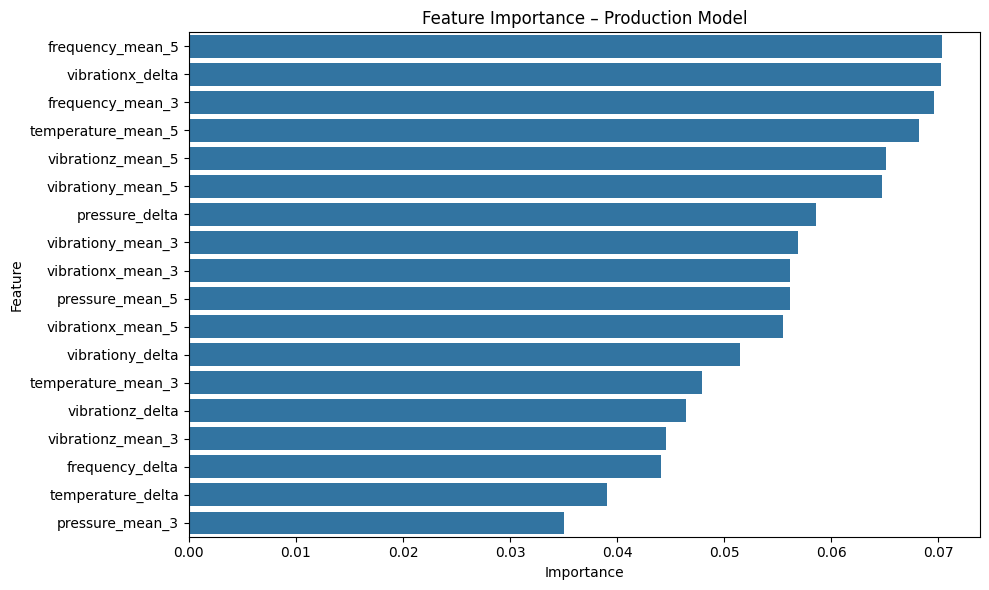

In [35]:
# Plots feature importance
def plot_feature_importance(
    model: XGBClassifier, feature_names: List[str], top_n: int = 20
) -> None:
    importance: np.ndarray = model.feature_importances_
    df_importance: pd.DataFrame = pd.DataFrame({
        "feature": feature_names,
        "importance": importance
    }).sort_values(by="importance", ascending=False).head(top_n)

    plt.figure(figsize=(10, 6))
    sns.barplot(data=df_importance, x="importance", y="feature")
    plt.title("Feature Importance – Production Model")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()

plot_feature_importance(model, features)

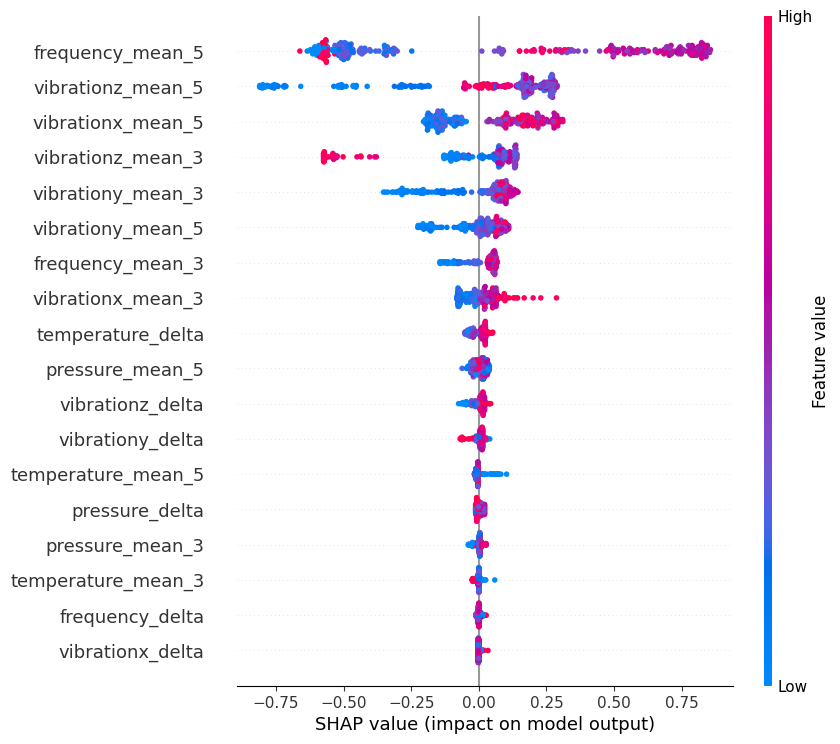

In [ ]:
explainer = shap.Explainer(model, X_train, feature_names=features)

# Compute SHAP values for the test set
shap_values = explainer(X_test)

# Plot the SHAP beeswarm chart to visualize feature importance
shap.plots.beeswarm(shap_values, max_display=20)

#### **Task 5 - Answer**

**1. Approach**  
- Two methods were used: XGBoost’s `feature_importance_` and SHAP (SHapley Additive exPlanations).

**2. XGBoost Results**  
- The most relevant variables were rolling means and deltas of frequency and vibration measurements.

**3. SHAP Results**  
- The SHAP plot confirmed that increases in frequency and vibration are strongly associated with a higher likelihood of failure.

**4. Conclusion**  
- Equipment failures are primarily influenced by variations in frequency and vibration, especially their recent averages. This indicates that the model effectively captures real early warning signals, making it valuable for proactive maintenance.
